In [1]:
import pandas as pd
import plotly.graph_objects as go
import numpy as np
import matplotlib as mpl 
import matplotlib
import matplotlib.pyplot as plt
import squarify
from matplotlib.pyplot import figure
import datetime
from datetime import datetime
import plotly.express as px
import math
import warnings
warnings.filterwarnings('ignore')
import time
from time import perf_counter
import glob
import csv
import importlib
import seaborn as sns
import json
from tqdm.notebook import tqdm
import sys
sys.path.append('C:/Users/gianl/Desktop/Gi/Supsi/BachelorProject/notebook/tweet_utils')
import tweets_utils
%autosave 3600

Autosaving every 3600 seconds


In [2]:
path_url = glob.glob("F:/Supsi/COVID-19-Tweets/large_files/urls/expanded_urls_*.csv")
expanded_urls = pd.DataFrame()
for i in path_url:
    expanded_urls = expanded_urls.append(pd.read_csv(i, low_memory=False, lineterminator="\n"))
    expanded_urls = expanded_urls[expanded_urls["expanded"].notna()]
    expanded_urls.drop('error', inplace=True, axis=1)
    expanded_urls.drop_duplicates(subset=['url'])
expanded_urls.reset_index(drop=True)
expanded_urls

,url,expanded
0,https://bit.ly/38SLstI,https://news.abs-cbn.com/news/01/29/20/cbcp-is...
1,http://dlvr.it/RP1y3X,https://www.theglobeandmail.com/world/article-...
2,https://trib.al/aYQ7ZIA,https://www.dailymail.co.uk/news/article-79390...
3,http://bit.ly/2tMEBmu,https://www.who.int/news-room/q-a-detail/q-a-c...
4,http://bit.ly/36HK7Vk,https://cnnphilippines.com/news/2020/1/31/pers...
...,...,...
49806,https://www.irishtimes.com/news/social-affairs...,https://www.irishtimes.com/news/social-affairs...
49807,https://www.irishtimes.com/news/social-affairs...,https://www.irishtimes.com/news/social-affairs...
49808,https://www.irishtimes.com/news/social-affairs...,https://www.irishtimes.com/news/social-affairs...
49809,https://www.irishtimes.com/news/social-affairs...,https://www.irishtimes.com/news/social-affairs...


In [3]:
cols = ["id", "id_str", "user_id", "user_screen_name", "text","in_reply_to_status_id",
        "in_reply_to_status_id_str" ,"in_reply_to_user_id" ,"in_reply_to_user_id_str" ,"in_reply_to_screen_name",
        "rt_created_at", "rt_in_reply_to_status_id", "rt_in_reply_to_user_id", "rt_id", "rt_user_id", "rt_created_at",
        "rt_user_screen_name", "quoted_status_id" ,"quoted_status_text" ,"quoted_status_created_at", "quoted_user_id",
        "quoted_user_created_at", "hashtags", "user_mentions", "urls", "retweet_count", "created_at"]

In [4]:
# scores and credibility
path =  glob.glob("F:/Supsi/COVID-19-Tweets/large_files/urls/")
scores = pd.read_csv(path[0] + "sum_of_urls_df_all_months_with_score.csv", low_memory=False, lineterminator="\n")
scores = scores[scores["conspiracy_score"].notna()]
scores = scores[scores["number_of_urls"]>=10]
scores = scores.reset_index(drop=True)

path_csv = glob.glob("C:/Users/gianl/Desktop/Gi/Supsi/BachelorProject/csv/")
credibility_url = pd.read_csv(path_csv[0] + "domain_credibility.csv")
bad_dozen_list = pd.read_csv(path_csv[0] + "disinformation_users.csv")
good_dozen_list = pd.read_csv(path_csv[0] + "good_dozen.csv")
good_users_list = pd.read_csv(path_csv[0] + "all_good_users.csv", low_memory=False, lineterminator="\n")
bad_fbme = pd.read_csv(path_csv[0] + "bad_fbme_decompress.csv", lineterminator="\n")

path_ccdh =  glob.glob("F:/Supsi/COVID-19-Tweets/large_files/ccdh/")
df_good_users_interactions = pd.read_csv(path_ccdh[0] + "all_good.csv", low_memory=False, lineterminator="\n")
df_bad_dozen_interactions = pd.read_csv(path_ccdh[0] + "bad_dozen.csv", low_memory=False, lineterminator="\n")

df_bad_activity = df_bad_dozen_interactions[df_bad_dozen_interactions["user_screen_name"].isin(list(bad_dozen_list["screen_name"]))]
df_good_activity = df_good_users_interactions[df_good_users_interactions["user_screen_name"].isin(list(good_users_list["screen_name"]))]

### Reminder:

<p> 

    df_good/bad_activity → DataFrame che contiene le attività attive delle due categorie (in cui sono loro ad effettuare qualcosa)

    df_bad/good_dozen_interactions → interazioni attive e passive (ma mancano i retweet grossi)
    
</p>

In [5]:
x = pd.read_csv("F:/Supsi/COVID-19-Tweets/large_files/ccdh/new_good.csv")
new_good = x[x["status"]=="verified"]
new_users = list(new_good["user"])
new_good

,user,status
0,KizzyPhD,verified
1,JuliaLMarcus,verified
2,KrutikaKuppalli,verified
3,gmleunghku,verified
4,DrMikeRyan,verified
...,...,...
94,johnbrownstein,verified
96,phylogenomics,verified
97,marcelsalathe,verified
98,neil_ferguson,verified


In [6]:
new_good_activity = df_good_activity[(df_good_activity['user_screen_name'].isin(new_users)) | 
                 (df_good_activity['in_reply_to_screen_name'].isin(new_users)) | 
                 (df_good_activity['rt_user_screen_name'].isin(new_users)) |
                 (df_good_activity['quoted_user_created_at'].isin(new_users))]

In [17]:
df_bad_split = tweets_utils.split_df(df_bad_activity)
df_good_split = tweets_utils.split_df(new_good_activity)

In [24]:
# name = list(df_good_activity["user_screen_name"])
# # link = list(df_good_activity["urls"])
# hashtag = list(df_good_activity["hashtags"])
good_rt_in = pd.DataFrame()
for chunk in tqdm(pd.read_csv(path_ccdh[0] + "good_dozen_rt.csv", lineterminator='\n', 
                         low_memory=False, usecols=cols, chunksize=int(1e6))):
    good_rt_in = good_rt_in.append(chunk)
    
new_good_rt_in = good_rt_in[(good_rt_in['rt_user_screen_name'].isin(new_users)) |
                 (good_rt_in['quoted_user_created_at'].isin(new_users))]    
    
bad_rt_in = pd.DataFrame()
for chunk in tqdm(pd.read_csv(path_ccdh[0] + "bad_dozen_rt_ricevuti.csv", lineterminator='\n', 
                         low_memory=False, usecols=cols, chunksize=int(1e6))):
    bad_rt_in = bad_rt_in.append(chunk)
    
#     link.extend(list(chunk["urls"]))
#      hashtag.extend(list(chunk["hashtags"]))
#     name.extend(list(chunk["user_screen_name"]))

Number of total tweets: 19159
Number of original tweets: 13182
Number of retweets: 2834
Number of replies: 1622
Number of quotes: 1521
Number of original_tweets: 68.8% of total tweets
Number of retweets: 14.79% of total tweets
Number of replies: 8.47% of total tweets
Number of quotes: 7.94% of total tweets
Check sum == len(tweets):  True


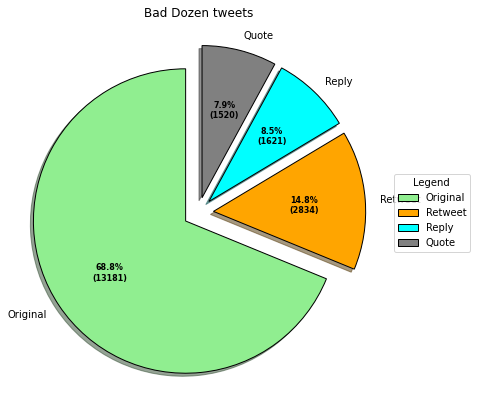

In [19]:
original_bad = df_bad_split["original"]
quote_bad = df_bad_split["quote"]
retweet_bad = df_bad_split["retweet"]
reply_bad = df_bad_split["reply"]
mentions_bad = df_bad_split["original_mention"]
reply_status_bad = df_bad_split['reply_to_status']
retweet_original_bad = df_bad_split['rt_original']
retweet_reply_bad = df_bad_split['rt_in_reply']
retweet_mention_bad = df_bad_split['rt_mention']
quote_original_bad = df_bad_split['quote_original']
quote_reply_bad = df_bad_split['quote_reply']
quote_mention_bad = df_bad_split['quote_mention']
total_len_bad = len(df_bad_activity) 
len_quote_bad = len(quote_bad)
len_original_bad = len(original_bad)
len_rt_bad = len(retweet_bad)
len_rp_bad = len(reply_bad)
len_mentions_bad = len(mentions_bad)
len_reply_status_bad = len(reply_status_bad)
len_retweet_original_bad = len(retweet_original_bad)
len_retweet_reply_bad = len(retweet_reply_bad)
len_retweet_mention_bad = len(retweet_mention_bad)
len_quote_original_bad = len(quote_original_bad)
len_quote_reply_bad = len(quote_reply_bad)
len_quote_mention_bad = len(quote_mention_bad)
tweets_utils.stats(total_len_bad, len_original_bad, len_rt_bad, len_rp_bad, len_quote_bad)
tweets_utils.print_pie_chart4("Bad Dozen tweets", "Original", "Retweet", "Reply", "Quote", len_original_bad, len_rt_bad, len_rp_bad, len_quote_bad)

Number of total tweets: 247339
Number of original tweets: 40721
Number of retweets: 103565
Number of replies: 77621
Number of quotes: 25432
Number of original_tweets: 16.46% of total tweets
Number of retweets: 41.87% of total tweets
Number of replies: 31.38% of total tweets
Number of quotes: 10.28% of total tweets
Check sum == len(tweets):  True


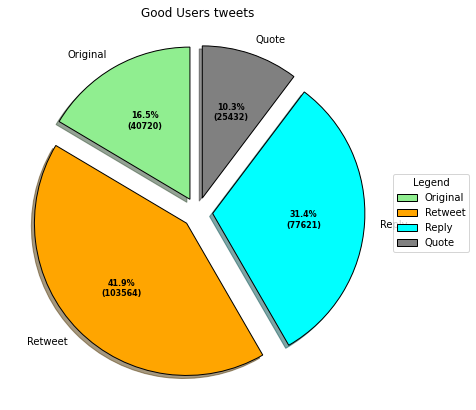

In [22]:
original_good = df_good_split["original"]
quote_good = df_good_split["quote"]
retweet_good = df_good_split["retweet"]
reply_good = df_good_split["reply"]
mentions_good = df_good_split["original_mention"]
reply_status_good = df_good_split['reply_to_status']
retweet_original_good = df_good_split['rt_original']
retweet_reply_good = df_good_split['rt_in_reply']
retweet_mention_good = df_good_split['rt_mention']
quote_original_good = df_good_split['quote_original']
quote_reply_good = df_good_split['quote_reply']
quote_mention_good = df_good_split['quote_mention']
total_len_good = len(new_good_activity) 
len_quote_good = len(quote_good)
len_original_good = len(original_good)
len_rt_good = len(retweet_good)
len_rp_good = len(reply_good)
len_mentions_good = len(mentions_good)
len_reply_status_good = len(reply_status_good)
len_retweet_original_good = len(retweet_original_good)
len_retweet_reply_good = len(retweet_reply_good)
len_retweet_mention_good = len(retweet_mention_good)
len_quote_original_good = len(quote_original_good)
len_quote_reply_good = len(quote_reply_good)
len_quote_mention_good = len(quote_mention_good)
tweets_utils.stats(total_len_good, len_original_good, len_rt_good, len_rp_good, len_quote_good)
tweets_utils.print_pie_chart4("Good Users tweets", "Original", "Retweet", "Reply", "Quote", len_original_good, len_rt_good, len_rp_good, len_quote_good)

# Stats
<a id="c_stats"/>

In [23]:
bad_values = [(len_original_bad/total_len_bad), (len_rt_bad/total_len_bad), (len_rp_bad/total_len_bad), (len_quote_bad/total_len_bad)]
good_values = [len_original_good/total_len_good, len_rt_good/total_len_good, len_rp_good/total_len_good, len_quote_good/total_len_good]
labels = ["Original", "Retweet", "Reply", "Quote"]

fig = go.Figure()
fig.add_trace(go.Histogram(histfunc="sum", y=bad_values, x=labels, name="Bad"))
fig.add_trace(go.Histogram(histfunc="sum", y=good_values, x=labels, name="Good"))
fig.update_layout(
    title="Differences between Bad Dozen and Good Users activity",
    xaxis_title="Kind of activity",
    yaxis_title="Percentage of activity",
    legend_title="Legend")
fig.show()


# Link shared by Dozen
<a id="link_sh"/>

In [7]:
importlib.reload(tweets_utils)
def substitute_compressed_url(df, flag = False, fbme = None, expanded_urls = expanded_urls):
    df_urls = df.loc[df['urls'] != '[]']
    df_urls = df.loc[df['urls'].notna()]
    urls = df_urls["urls"]
    val = []
    for i in urls:
        if type(i) == float:
            print(i)
        else:
            val.append(i)
    val = [i for i in val if i != "[]"]
    print(len(val))
#     for i in val:
#         print(i)
#         print(type(i))
#         print(i.split()[3])
    val = [x.split()[3].translate({ord("'"): None}).replace(",","") for x in val]
    df_urls = pd.DataFrame(val, columns=["urls"])
    df_merge = df_urls.merge(expanded_urls, how="left", left_on="urls", right_on="url")
    x = df_merge[df_merge["url"].notna()]
    if flag:
        y = df_urls.merge(fbme, left_on="urls", right_on="compressed", how="left")
        y = y[y["compressed"].notna()]
        for index, row in tqdm(y.iterrows()):
            df_urls.loc[df_urls["urls"]==row["compressed"], "urls"] = row["decompressed"]
    print(len(x))
    for index, row in tqdm(x.iterrows()):
        df_urls.loc[df_urls["urls"]==row["url"], "urls"] = row["expanded"]
    print("Beautify...")
    urls = df_urls["urls"]
    urls = [tweets_utils.url_decompress(v) for v in urls]
    urls = tweets_utils.remove_www(urls)
    return urls

In [8]:
df_good_activity_urls = substitute_compressed_url(new_good_activity)
df_bad_activity_urls = substitute_compressed_url(df_bad_activity, True, bad_fbme)

115246
134



Beautify...
14890



8



Beautify...
['not found']
invalid data
['not found']
invalid data
['not found']
invalid data
['not found']
invalid data
['not found']
invalid data
['not found']
invalid data
['not found']
invalid data
['not found']
invalid data
['not found']
invalid data
['not found']
invalid data
['not found']
invalid data
['not found']
invalid data
['not found']
invalid data
['not found']
invalid data
['not found']
invalid data
['not found']
invalid data
['not found']
invalid data
['not found']
invalid data
['not found']
invalid data
['not found']
invalid data
['not found']
invalid data
['not found']
invalid data
['not found']
invalid data
['not found']
invalid data
['not found']
invalid data
['not found']
invalid data
['not found']
invalid data


In [9]:
# print(len(df_good_urls)/len(good_dozen_list["screen_name"]))
# print(len(df_bad_urls)/len(bad_dozen_list["screen_name"]))
# df_gg = pd.Series(df_good_activity_urls).value_counts().sort_values(ascending=False)
# df_gg[:15]

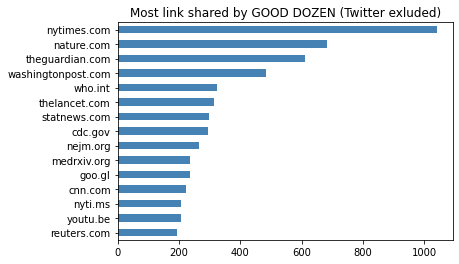

In [32]:
val = pd.Series(df_good_activity_urls).value_counts().sort_values(ascending=False)
val.drop(val.index[0], inplace=True)
val.drop(val.index[0], inplace=True)
# val.drop(val.index[1], inplace=True)
val.drop(val.index[4], inplace=True)
# val.drop(val.index[12], inplace=True)
fig = plt.figure()
ax = val[:15].plot(kind='barh', color='steelblue')
ax.set_title('Most link shared by GOOD DOZEN (Twitter exluded)')
ax.invert_yaxis()
plt.show()

In [147]:
df_bad_urls = pd.DataFrame(df_bad_activity_urls, columns =['Url'])
good_url = pd.Series(df_good_activity_urls).value_counts().sort_values(ascending=False)
x = df_bad_urls[df_bad_urls["Url"].isin(list(good_url[1:20].keys()))]
bad_url = pd.Series(x["Url"]).value_counts().sort_values(ascending=False)
ind = []
type_b = []
type_g = []
for i in good_url[1:20].keys():
    type_g.append("Good")
    type_b.append("Bad")
    if i in bad_url:
        continue
    else:
        bad_url = bad_url.append(pd.Series(0,index=[i]))
bad_url
good_urls_values = list(good_url[1:20].values)
good_urls_keys = list(good_url[1:20].keys())
bad_urls_values = list(bad_url.values)
bad_urls_keys = list(bad_url.keys())
df_plot_good = pd.DataFrame(zip(good_urls_values, good_urls_keys, type_g), columns=["Count", "Url", "Dozen"])
df_plot_bad = pd.DataFrame(zip(bad_urls_values, bad_urls_keys, type_b), columns=["Count", "Url", "Dozen"])
df_plot = df_plot_good.append(df_plot_bad)
df_plot = df_plot.reset_index(drop = True)

In [145]:
# value_good = df_plot.loc[2]["Val"] + df_plot.loc[3]["Val"]
# value_bad = df_plot.loc[17]["Val"] + df_plot.loc[18]["Val"]
# df_plot.loc[df_plot.index == 3, 'Val'] = value_good
# df_plot.loc[df_plot.index == 18, 'Val'] = value_bad
# df_plot

In [149]:
df_plot.loc[df_plot.index == 16, 'Count'] = 1192
df_plot.loc[df_plot.index == 16, 'Url'] = "youtube.com"
df_plot.loc[df_plot.index == 19, 'Count'] = 574
df_plot.loc[df_plot.index == 19, 'Url'] = "youtube.com"

In [151]:
a = ["bit.ly", "shar.es", "ow.ly", "dlvr.it", "ift.tt", "nyti.ms", "zpr.io"]
df_plot = df_plot[~df_plot["Url"].isin(a)]

df_plot = df_plot.sort_values(by="Count", ascending=False)
fig = px.bar(df_plot, color_discrete_sequence=['blue', "red"], x="Count", y="Url", color="Dozen", barmode='group', title="Top 15 Good Dozen domain shared (with comparison)")
fig.update_layout(
        font_size = 15,
    yaxis = dict(autorange="reversed"))
fig.show()

In [15]:
val = pd.Series(df_good_activity_urls).value_counts().sort_values(ascending=False)
labels = list(val[2:18].keys())
values = list(val[2:18].values)
labels.pop(4)
values.pop(4)

335

In [16]:
dddf = pd.DataFrame(list(zip(labels, values)), 
                    columns=["labels", "values"])
fig = px.treemap(dddf, path=['labels'],values='values', width=800, height=500)
colors = ["#154360", "#1b4f72", "#1a5276", "#21618c", "#1f618d",
         "#2874a6", "#2471a3", "#2e86c1", "#2980b9", "#3498db",
         "#5499c7", "#5dade2", "#7fb3d5", "#85c1e9", "#a9cce3"]
fig.update_layout(
    treemapcolorway = colors, #defines the colors in the treemap
    margin = dict(t=50, l=25, r=25, b=25))
fig.show()

### Youtube Domain
<a id="yt"/>

#### Good
<a id="good_yt"/>

In [21]:
# df_urls = df_good_activity.loc[df_good_activity['urls'] != '[]']
# val = [x.split()[3].translate({ord("'"): None}).replace(",","") for x in df_urls["urls"]]
# val = [x if ("https://youtu.be" in x) or ("https://www.youtube.com" in x) else np.nan for x in val]
# df_urls["urls"] = val
# df_urls = df_urls[["user_screen_name", "urls"]]
# df_urls = df_urls[df_urls["urls"].notna()]
# df_urls.rename(columns={'urls': 'URL', "user_screen_name": "NAME"}, inplace=True)
# df_urls.to_csv(path_csv[0] + "good_dozen_yt_urls.csv", line_terminator="\n", 
#               encoding="utf-8", index=False)

In [6]:
path_urls = glob.glob("F:/Supsi/COVID-19-Tweets/large_files/urls/")
yt_df = pd.read_csv(path_urls[0] + "yt_good_parsed.csv", lineterminator="\n")
df_urls = df_good_activity.loc[df_good_activity['urls'] != '[]']
val = [x.split()[3].translate({ord("'"): None}).replace(",","") for x in df_urls["urls"]]
val = [x if ("https://youtu.be" in x) or ("https://www.youtube.com" in x) else np.nan for x in val]
df_urls["urls"] = val
df_urls = df_urls[["retweet_count", "urls"]]
df_urls = df_urls[df_urls["urls"].notna()]
merge = yt_df.merge(df_urls, left_on="url", right_on="urls", how="left")
merge.sort_values(by=["retweet_count"], ascending=False)

,user_name,title,description,url,type,available,reason,retweet_count,urls
813,Ryan_Mac_Phd,How to person woman man camera tv,NaN,https://youtu.be/j8oaaP68i4s,compressed,True,Parsed,35309.0,https://youtu.be/j8oaaP68i4s
272,DrJayVarma,Hasan Hears Hot Takes From The Audience | Deep...,"On the latest Deep Cuts, Hasan hears some hot ...",https://youtu.be/sYShB-DzYO8,compressed,True,Parsed,25286.0,https://youtu.be/sYShB-DzYO8
861,VirusesImmunity,mRNA ワクチンの有効性と安全性,mRNAワクチンとは何でしょうか？新型コロナに有効なのでしょうか？安全でしょうか？どのような...,https://youtu.be/uv9lVaxA8NY,compressed,True,Parsed,7406.0,https://youtu.be/uv9lVaxA8NY
565,ChristoPhraser,This Tortoise Could Save a Life - Ft. Alan Ric...,"By watching this, you have donated to Save the...",https://www.youtube.com/watch?v=HkiMz-e2ZcE&fe...,decompressed,True,Parsed,2742.0,https://www.youtube.com/watch?v=HkiMz-e2ZcE&fe...
187,Bob_Wachter,Homer Simpson Conducts Conan’s TBS Exit Interv...,Conan has one last order of business before he...,https://youtu.be/gFfgrPm7-KY,compressed,True,Parsed,1892.0,https://youtu.be/gFfgrPm7-KY
...,...,...,...,...,...,...,...,...,...
958,CarlosdelRio7,VACUNATE POR TODOS - vacunas contra el COVID-1...,HITN presenta “Vacúnate por Todos”; un program...,https://youtu.be/z6pmWYk2CcA,compressed,True,Parsed,0.0,https://youtu.be/z6pmWYk2CcA
514,RELenski,Dean Martin - That's Amore,Dean Martin on Google Play: https://play.googl...,https://www.youtube.com/watch?v=OnFlx2Lnr9Q,decompressed,True,Parsed,0.0,https://www.youtube.com/watch?v=OnFlx2Lnr9Q
517,RELenski,"What's Up, Doc? (1972) - Howard's Send-Off Sce...","What's Up, Doc? movie clips: http://j.mp/1zhof...",https://www.youtube.com/watch?v=dR0_tMYKwXE,decompressed,True,Parsed,0.0,https://www.youtube.com/watch?v=dR0_tMYKwXE
518,RELenski,"Graham: Trump a 'race-baiting, xenophobic reli...",Sen. Lindsey Graham had harsh words for fellow...,https://www.youtube.com/watch?v=2bkDykGhM8c,decompressed,True,Parsed,0.0,https://www.youtube.com/watch?v=2bkDykGhM8c


In [8]:
merge["retweet_count"].sum()

101613.0

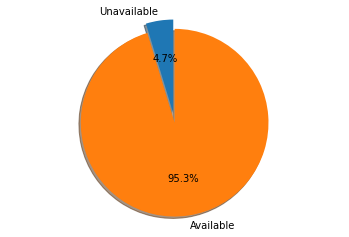

In [24]:
av = len(yt_df[yt_df["reason"]=="Unavailable"])
unav = len(yt_df[yt_df["reason"]=="Parsed"])
labels = 'Unavailable', 'Available'
sizes = [av, unav]
explode = (0, 0.1)  
fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')
plt.show()

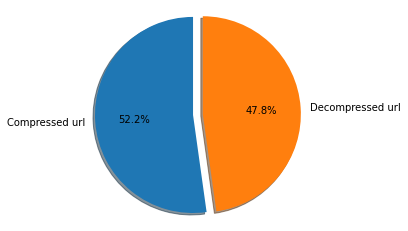

In [25]:
comp = len(yt_df[yt_df["type"]=="compressed"])
decomp = len(yt_df[yt_df["type"]=="decompressed"])

labels = 'Compressed url', 'Decompressed url'
sizes = [comp, decomp]
explode = (0, 0.1)  
fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')
plt.show()

#### Rt Bad

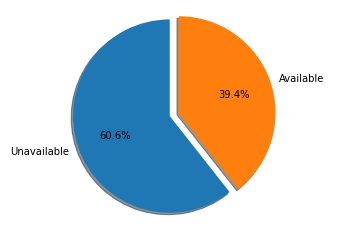

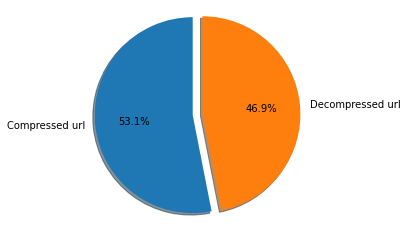

In [47]:
path_urls = glob.glob("F:/Supsi/COVID-19-Tweets/large_files/urls/")
yt_df = pd.read_csv(path_urls[0] + "yt_bad_rt_parsed.csv", lineterminator="\n")
av = len(yt_df[yt_df["reason"]=="Unavailable"])
unav = len(yt_df[yt_df["reason"]=="Parsed"])
labels = 'Unavailable', 'Available'
sizes = [av, unav]
explode = (0, 0.1)  
fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')
plt.show()
comp = len(yt_df[yt_df["type"]=="compressed"])
decomp = len(yt_df[yt_df["type"]=="decompressed"])

labels = 'Compressed url', 'Decompressed url'
sizes = [comp, decomp]
explode = (0, 0.1)  
fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')
plt.show()

#### SAGE on YouTube
<a id="sage_yt"/>

In [31]:
sage_description = pd.read_csv("F:/Supsi/COVID-19-Tweets/large_files/sage_data/yt_description_sage.csv",
                              lineterminator="\n", low_memory=False)
sage_description

,source,word,sage,file_count,file_rate,base_count,base_rate
0,.\data\bad_yt_descriptions.txt,amend,1.952158,27,0.001510,27,0.000323
1,.\data\bad_yt_descriptions.txt,dore,1.947712,25,0.001398,25,0.000299
2,.\data\bad_yt_descriptions.txt,fox,1.912785,56,0.003131,60,0.000718
3,.\data\bad_yt_descriptions.txt,cable,1.907644,15,0.000839,15,0.000180
4,.\data\bad_yt_descriptions.txt,fnc,1.907644,15,0.000839,15,0.000180
5,.\data\bad_yt_descriptions.txt,valuetainment,1.882488,12,0.000671,12,0.000144
6,.\data\bad_yt_descriptions.txt,awakening,1.882488,12,0.000671,12,0.000144
7,.\data\bad_yt_descriptions.txt,sears,1.882488,12,0.000671,12,0.000144
8,.\data\bad_yt_descriptions.txt,nrule,1.882488,12,0.000671,12,0.000144
9,.\data\bad_yt_descriptions.txt,censorship,1.882488,12,0.000671,12,0.000144


In [32]:
sage_title = pd.read_csv("F:/Supsi/COVID-19-Tweets/large_files/sage_data/yt_title_sage.csv",
                              lineterminator="\n", low_memory=False)
sage_title

,source,word,sage,file_count,file_rate,base_count,base_rate
0,.\data\bad_yt_titles.txt,right,1.910087,7,0.005132,8,0.001056
1,.\data\bad_yt_titles.txt,told,1.872861,4,0.002933,4,0.000528
2,.\data\bad_yt_titles.txt,byron,1.872861,4,0.002933,4,0.000528
3,.\data\bad_yt_titles.txt,reparations,1.872861,4,0.002933,4,0.000528
4,.\data\bad_yt_titles.txt,truth,1.857430,6,0.004399,7,0.000924
5,.\data\bad_yt_titles.txt,agenda,1.783770,5,0.003666,6,0.000792
6,.\data\bad_yt_titles.txt,election,1.739247,3,0.002199,3,0.000396
7,.\data\bad_yt_titles.txt,americans,1.739247,3,0.002199,3,0.000396
8,.\data\bad_yt_titles.txt,pleiadian,1.739247,3,0.002199,3,0.000396
9,.\data\bad_yt_titles.txt,heated,1.739247,3,0.002199,3,0.000396


# Hashtags
<a id="comp_hashtag"/>

In [34]:
from datetime import date
def get_series(hash_date, name):
    d = hash_date[hash_date["hashtag"]==name]["date"]
    dates_list = []
    for i in list(d):
        x = i.split()[0]
        if not "2" in x:
            x = tweets_utils.process_datetime(i)        
        dates_list.append(datetime.strptime(x, '%Y-%m-%d'))
    serie = pd.Series(dates_list, name=name).value_counts().sort_index()
    return serie

In [35]:
def plot_lines(hashtags, hash_date):
    df = pd.DataFrame()
    x = []
    for i in range(len(hashtags)):
        x.append(get_series(hash_date, hashtags[i]))
    df = pd.concat([i for i in x], axis=1)
    df = df.fillna(0)
    df.sort_index(ascending=True, inplace=True)
    lines = df.plot.line(figsize=(14,6))
    lines.set_xlim([df.first_valid_index(), df.last_valid_index()])

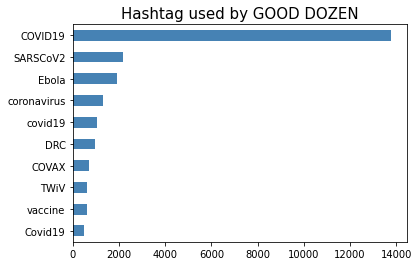

In [37]:
val = pd.Series(tweets_utils.hashtag_process(new_good_activity))
val = val.value_counts().sort_values(ascending=False)
fig = plt.figure()
ax = val[:10].plot(kind='barh', color='steelblue') #red #darkturquoise
ax.set_title('Hashtag used by GOOD DOZEN', fontsize=15)
ax.invert_yaxis()
plt.show()

In [55]:
labels = list(val[:17].keys())
values = list(val[:17].values)
# print(labels)
# print(values)
# for i in range(len(values)):
#     print(str(labels[i]) + " - " + str(values[i]))
labels = ["COVID19", "Ebola", "DRC", "COVAX", "TWiV",
          "vaccine", "shoutout", "Africa", "womenInSTEM", "science"]
covid = 13787 + 2163 + 1321 + 1040 + 505 + 465 + 450
vaccines = 360 + 628
values = [covid, 1923, 956, 720, 637, vaccines, 451, 448, 419, 357]

In [56]:

dddf = pd.DataFrame(list(zip(labels, values)), 
                    columns=["labels", "values"])
fig = px.treemap(dddf, path=['labels'],values='values', width=800, height=500)
colors = ["#154360", "#1b4f72", "#1a5276", "#21618c", "#1f618d",
         "#2874a6", "#2471a3", "#2e86c1", "#2980b9", "#3498db",
         "#5499c7", "#5dade2", "#7fb3d5", "#85c1e9", "#a9cce3"]
fig.update_layout(
    treemapcolorway = colors, #defines the colors in the treemap
    margin = dict(t=50, l=25, r=25, b=25))
fig.show()


# Sage

In [8]:
sage_text = pd.read_csv("C:/Users/gianl/Desktop/Gi/Supsi/BachelorProject/sage/data/sage_text_new_good.csv",
                       lineterminator="\n", low_memory=False)
sage_text

,source,word,sage,file_count,file_rate,base_count,base_rate
0,C:\Users\gianl\Desktop\Gi\Supsi\BachelorProjec...,amp,0.050307,20315,0.009135,20315,0.009135
1,C:\Users\gianl\Desktop\Gi\Supsi\BachelorProjec...,covid,0.050191,18270,0.008215,18270,0.008215
2,C:\Users\gianl\Desktop\Gi\Supsi\BachelorProjec...,covid19,0.050068,16529,0.007432,16529,0.007432
3,C:\Users\gianl\Desktop\Gi\Supsi\BachelorProjec...,vaccine,0.049882,14451,0.006498,14451,0.006498
4,C:\Users\gianl\Desktop\Gi\Supsi\BachelorProjec...,new,0.049794,13646,0.006136,13646,0.006136
5,C:\Users\gianl\Desktop\Gi\Supsi\BachelorProjec...,health,0.049730,13110,0.005895,13110,0.005895
6,C:\Users\gianl\Desktop\Gi\Supsi\BachelorProjec...,people,0.049497,11490,0.005167,11490,0.005167
7,C:\Users\gianl\Desktop\Gi\Supsi\BachelorProjec...,us,0.049398,10921,0.004911,10921,0.004911
8,C:\Users\gianl\Desktop\Gi\Supsi\BachelorProjec...,19,0.048904,8778,0.003947,8778,0.003947
9,C:\Users\gianl\Desktop\Gi\Supsi\BachelorProjec...,one,0.048837,8555,0.003847,8555,0.003847
